https://www.kaggle.com/datasets/batuhanyil/electron-microscopy-particle-segmentation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#1- Import Libraries
import os
import glob
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
#2- Define Paths:
image_folder = '/content/drive/MyDrive/DataScience/Microscopy_Segmentation/data/images/'
mask_folder = '/content/drive/MyDrive/DataScience/Microscopy_Segmentation/data/segmaps/'
#image_folder = 'data/images/'
#mask_folder = 'data/segmaps/'

In [5]:
#3- Split Data into training, validation, and testing sets

# Get all image file names
image_filenames_path = sorted(glob.glob(os.path.join(image_folder, "*.png")))
mask_filenames_path = sorted(glob.glob(os.path.join(mask_folder, "*.png")))
assert len(image_filenames_path) == len(mask_filenames_path), "Number of images and masks do not match"
# Remove path
image_filenames = [file.split('/')[-1] for file in image_filenames_path]

val_size=0.2
test_size=0.1

# Split into training and testing sets
train_filenames, test_filenames = train_test_split(image_filenames, test_size=test_size, random_state=42)

# Split training set into training and validation sets
train_filenames, val_filenames = train_test_split(train_filenames, test_size=val_size/(1-test_size), random_state=42)

# Print number of samples in each set
print(f'Total Images: {len(image_filenames)}')
print(f'Total Masks: {len(mask_filenames_path)}')
print(f'Training samples: {len(train_filenames)}')
print(f'Validation samples: {len(val_filenames)}')
print(f'Testing samples: {len(test_filenames)}')

Total Images: 465
Total Masks: 465
Training samples: 325
Validation samples: 93
Testing samples: 47


In [6]:
#4- Define custom Datasets, data augmentation, Data Loaders

class CustomDataset(Dataset):
    def __init__(self, image_filenames, mask_filenames, transforms=None):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        image_name = self.image_filenames[idx]
        img_path = os.path.join(image_folder, self.image_filenames[idx])
        mask_path = os.path.join(mask_folder, self.mask_filenames[idx])

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        if self.transforms is not None:
            seed = np.random.randint(2023)
            
            random.seed(seed)
            torch.manual_seed(seed)
            image = self.transforms(image)
            
            random.seed(seed)
            torch.manual_seed(seed)
            mask = self.transforms(mask)
            
        mask = np.array(mask)
        mask = (mask > 0).astype(np.float32) # astype() -> boolean matrix to float, true = 1.0 and False = 0.0.
        mask = torch.from_numpy(mask)
 
        return image, mask

In [7]:
# Define data augmentation

image_size = (224, 224)

train_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-90,90)),
    transforms.ToTensor()
])

val_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

In [8]:
# Create datasets and data loaders
train_dataset = CustomDataset(train_filenames, train_filenames, train_transforms)
val_dataset = CustomDataset(val_filenames, val_filenames, val_transforms)
test_dataset = CustomDataset(test_filenames, test_filenames, val_transforms)

batch_size = 20
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

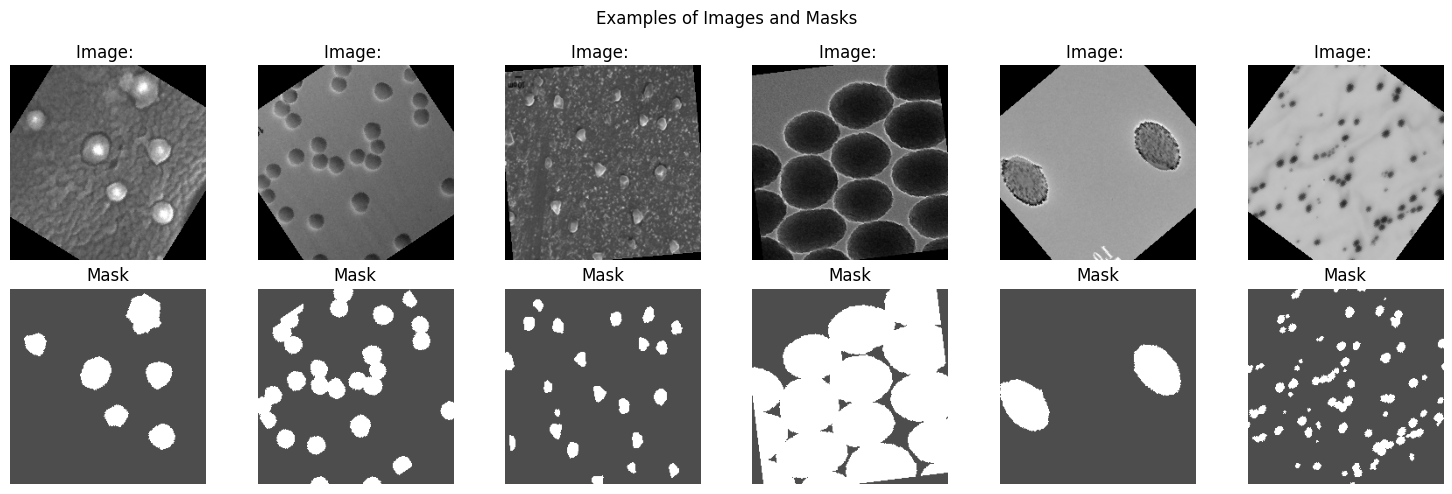

In [9]:
#5- Plot examples of image and mask pairs

images, masks = next(iter(train_loader))

def plot_image_mask_pairs(images, masks, num_pairs=6):
    fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(15, 5))
    fig.suptitle('Examples of Images and Masks')

    for i in range(num_pairs):
        # Plot image
        axs[0, i].imshow(images[i].permute(1,2,0))
        axs[0, i].set_title('Image: ')
        axs[0, i].axis('off')    
        # Plot mask
        axs[1, i].imshow(masks[i].squeeze(dim=0), alpha=0.7, cmap='gray')
        axs[1, i].set_title('Mask')
        axs[1, i].axis('off')

    plt.tight_layout()    
    plt.show()

plot_image_mask_pairs(images, masks)

In [10]:
images[0].type(), masks[0].type()

('torch.FloatTensor', 'torch.FloatTensor')

In [11]:
images[0].size(), masks[0].size()

(torch.Size([3, 224, 224]), torch.Size([1, 224, 224]))

In [12]:
def iou_score(output, target):
    smooth = 1e-6
    intersection = (output * target).sum()
    union = output.sum() + target.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()

def jaccard_score(output, target):
    smooth = 1e-6
    intersection = (output * target).sum()
    union = output.sum() + target.sum() - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    return jaccard.item()

def f1_score(output, target):
    smooth = 1e-6
    intersection = (output * target).sum()
    f1 = (2 * intersection + smooth) / (output.sum() + target.sum() + smooth)
    return f1.item()

def dice_score(output, target):
    smooth = 1e-6
    intersection = (output * target).sum()
    dice = (2 * intersection + smooth) / (output.sum() + target.sum() + smooth)
    return dice.item()

In [15]:
#7- Define pretrained Model

!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch --quiet
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)
model.to(device)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [16]:
#8- Define Loss Function, Optimizer, scheduler and Early Stopping class:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [17]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss)
        elif score < self.best_score + 0.001:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss)
            self.counter = 0

    def save_checkpoint(self, val_loss):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss}, 'best_model_SMP.pth') 
        
# Initialize early stopping class
early_stopping = EarlyStopping(patience=10, verbose=True)

In [18]:
#9a- Define and execute Training Loop and Validation loop

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train() # model.train()
    running_loss = 0.0
    running_iou = 0.0
    running_jaccard = 0
    running_f1 = 0
    running_dice = 0
    for images, masks in tqdm(dataloader, leave=False):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        running_iou += iou_score(outputs, masks) * images.size(0)
        running_jaccard += jaccard_score(outputs, masks) * images.size(0)
        running_f1 += f1_score(outputs, masks) * images.size(0)
        running_dice += dice_score(outputs, masks) * images.size(0)
        #train_iou += iou_score(outputs > 0.5, masks > 0.5).item()
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_iou = running_iou / len(dataloader.dataset)
    epoch_jaccard = running_jaccard / len(dataloader.dataset)
    epoch_f1 = running_f1 / len(dataloader.dataset)
    epoch_dice = running_dice / len(dataloader.dataset)
    #train_iou /= len(train_loader)
    return epoch_loss, epoch_iou, epoch_jaccard, epoch_f1, epoch_dice

In [19]:
#9b- Define and execute Training Loop and Validation loop

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval() # model.eval()
    running_loss = 0.0
    running_iou = 0.0
    running_jaccard = 0
    running_f1 = 0
    running_dice = 0
    with torch.no_grad():
        for images, masks in tqdm(dataloader, leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            running_loss += loss.item() * images.size(0)
            running_iou += iou_score(outputs, masks) * images.size(0)
            running_jaccard += jaccard_score(outputs, masks) * images.size(0)
            running_f1 += f1_score(outputs, masks) * images.size(0)
            running_dice += dice_score(outputs, masks) * images.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_iou = running_iou / len(dataloader.dataset)
    epoch_jaccard = running_jaccard / len(dataloader.dataset)
    epoch_f1 = running_f1 / len(dataloader.dataset)
    epoch_dice = running_dice / len(dataloader.dataset)
    return epoch_loss, epoch_iou, epoch_jaccard, epoch_f1, epoch_dice

In [20]:
#9c- Define and execute Training Loop and Validation loop

def main(train_loader, val_loader, num_epochs = 0):    
   
    train_loss_history, val_loss_history, train_iou_history, val_iou_history = [], [], [], []
    train_jaccard_history, val_jaccard_history, train_f1_history, val_f1_history = [], [], [], []
    train_dice_history, val_dice_history = [], []
    
    for epoch in range(num_epochs):
        train_loss, train_iou, train_jaccard, train_f1, train_dice = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_iou, val_jaccard, val_f1, val_dice = validate_one_epoch(model, val_loader, criterion, device)
        scheduler.step(val_loss)
        early_stopping(val_loss)
        if early_stopping.early_stop:
            break
        
        train_loss_history.append(train_loss)
        train_iou_history.append(train_iou)
        train_jaccard_history.append(train_jaccard)
        train_f1_history.append(train_f1)
        train_dice_history.append(train_dice)
        
        val_loss_history.append(val_loss)
        val_iou_history.append(val_iou)
        val_jaccard_history.append(val_jaccard)
        val_f1_history.append(val_f1)
        val_dice_history.append(val_dice)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, ")
        print(f"Train IoU: {train_iou:.4f}, Val IoU: {val_iou:.4f}, ")
        print(f"Train Jaccard: {train_jaccard:.4f}, Val Jaccard: {val_jaccard:.4f}, ")
        print(f"Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}, ")
        print(f"Train Dice: {train_dice:.4f}, Val Dice: {val_dice:.4f}")
        
        results_dict = {
            'train_loss_history': train_loss_history,
            'val_loss_history': val_loss_history,
            'train_iou_history': train_iou_history,
            'val_iou_history': val_iou_history,
            'train_jaccard_history': train_jaccard_history,
            'val_jaccard_history': val_jaccard_history,
            'train_f1_history': train_f1_history,
            'val_f1_history': val_f1_history,
            'train_dice_history': train_dice_history,
            'val_dice_history': val_dice_history}        
    return results_dict

# run def main()
results_dict = main(train_loader, val_loader, num_epochs = 100)


Validation loss decreased (inf --> 0.983189).  Saving model ...
Epoch 1/100
Train Loss: 0.4535, Val Loss: 0.9832, 
Train IoU: -0.4429, Val IoU: 2.7784, 
Train Jaccard: -0.4429, Val Jaccard: 2.7784, 
Train F1: -74.6416, Val F1: 1.3818, 
Train Dice: -74.6416, Val Dice: 1.3818


Validation loss decreased (inf --> 0.276873).  Saving model ...
Epoch 2/100
Train Loss: 0.3280, Val Loss: 0.2769, 
Train IoU: -0.2550, Val IoU: -0.2153, 
Train Jaccard: -0.2550, Val Jaccard: -0.2153, 
Train F1: -0.6959, Val F1: -0.5526, 
Train Dice: -0.6959, Val Dice: -0.5526


EarlyStopping counter: 1 out of 10
Epoch 3/100
Train Loss: 0.2704, Val Loss: 0.3592, 
Train IoU: -0.2876, Val IoU: -0.5368, 
Train Jaccard: -0.2876, Val Jaccard: -0.5368, 
Train F1: -0.8143, Val F1: -2.7966, 
Train Dice: -0.8143, Val Dice: -2.7966


Validation loss decreased (inf --> 0.239462).  Saving model ...
Epoch 4/100
Train Loss: 0.2361, Val Loss: 0.2395, 
Train IoU: -0.2860, Val IoU: -0.1825, 
Train Jaccard: -0.2860, Val Jaccard: -0.1825, 
Train F1: -0.8056, Val F1: -0.4610, 
Train Dice: -0.8056, Val Dice: -0.4610


Validation loss decreased (inf --> 0.217051).  Saving model ...
Epoch 5/100
Train Loss: 0.2387, Val Loss: 0.2171, 
Train IoU: -0.2965, Val IoU: -0.2824, 
Train Jaccard: -0.2965, Val Jaccard: -0.2824, 
Train F1: -0.8493, Val F1: -0.8460, 
Train Dice: -0.8493, Val Dice: -0.8460


EarlyStopping counter: 1 out of 10
Epoch 6/100
Train Loss: 0.1823, Val Loss: 0.2336, 
Train IoU: -0.3755, Val IoU: -0.6967, 
Train Jaccard: -0.3755, Val Jaccard: -0.6967, 
Train F1: -1.2060, Val F1: 4.0010, 
Train Dice: -1.2060, Val Dice: 4.0010


EarlyStopping counter: 2 out of 10
Epoch 7/100
Train Loss: 0.2025, Val Loss: 0.4284, 
Train IoU: -0.3525, Val IoU: -2.8976, 
Train Jaccard: -0.3525, Val Jaccard: -2.8976, 
Train F1: -1.0944, Val F1: 2.2378, 
Train Dice: -1.0944, Val Dice: 2.2378


EarlyStopping counter: 3 out of 10
Epoch 8/100
Train Loss: 0.1688, Val Loss: 0.2583, 
Train IoU: -0.3521, Val IoU: -0.3986, 
Train Jaccard: -0.3521, Val Jaccard: -0.3986, 
Train F1: -1.0896, Val F1: -1.4899, 
Train Dice: -1.0896, Val Dice: -1.4899


EarlyStopping counter: 4 out of 10
Epoch 9/100
Train Loss: 0.1985, Val Loss: 0.2319, 
Train IoU: -0.3658, Val IoU: -0.2535, 
Train Jaccard: -0.3658, Val Jaccard: -0.2535, 
Train F1: -1.1610, Val F1: -0.7143, 
Train Dice: -1.1610, Val Dice: -0.7143


Validation loss decreased (inf --> 0.190371).  Saving model ...
Epoch 10/100
Train Loss: 0.1744, Val Loss: 0.1904, 
Train IoU: -0.3453, Val IoU: -0.2636, 
Train Jaccard: -0.3453, Val Jaccard: -0.2636, 
Train F1: -1.0596, Val F1: -0.7454, 
Train Dice: -1.0596, Val Dice: -0.7454


EarlyStopping counter: 1 out of 10
Epoch 11/100
Train Loss: 0.1734, Val Loss: 0.1988, 
Train IoU: -0.3475, Val IoU: -0.3565, 
Train Jaccard: -0.3475, Val Jaccard: -0.3565, 
Train F1: -1.0681, Val F1: -1.2037, 
Train Dice: -1.0681, Val Dice: -1.2037


Validation loss decreased (inf --> 0.142520).  Saving model ...
Epoch 12/100
Train Loss: 0.1524, Val Loss: 0.1425, 
Train IoU: -0.3557, Val IoU: -0.3823, 
Train Jaccard: -0.3557, Val Jaccard: -0.3823, 
Train F1: -1.1096, Val F1: -1.3546, 
Train Dice: -1.1096, Val Dice: -1.3546


EarlyStopping counter: 1 out of 10
Epoch 13/100
Train Loss: 0.1286, Val Loss: 0.1510, 
Train IoU: -0.3618, Val IoU: -0.4153, 
Train Jaccard: -0.3618, Val Jaccard: -0.4153, 
Train F1: -1.1369, Val F1: -1.6028, 
Train Dice: -1.1369, Val Dice: -1.6028


EarlyStopping counter: 2 out of 10
Epoch 14/100
Train Loss: 0.1150, Val Loss: 0.1505, 
Train IoU: -0.3735, Val IoU: -0.4547, 
Train Jaccard: -0.3735, Val Jaccard: -0.4547, 
Train F1: -1.1945, Val F1: -1.8947, 
Train Dice: -1.1945, Val Dice: -1.8947


Validation loss decreased (inf --> 0.140393).  Saving model ...
Epoch 15/100
Train Loss: 0.1056, Val Loss: 0.1404, 
Train IoU: -0.3791, Val IoU: -0.2267, 
Train Jaccard: -0.3791, Val Jaccard: -0.2267, 
Train F1: -1.2267, Val F1: -0.6012, 
Train Dice: -1.2267, Val Dice: -0.6012


EarlyStopping counter: 1 out of 10
Epoch 16/100
Train Loss: 0.1217, Val Loss: 0.2552, 
Train IoU: -0.3762, Val IoU: -0.7917, 
Train Jaccard: -0.3762, Val Jaccard: -0.7917, 
Train F1: -1.2137, Val F1: 9.3465, 
Train Dice: -1.2137, Val Dice: 9.3465


Validation loss decreased (inf --> 0.137454).  Saving model ...
Epoch 17/100
Train Loss: 0.1085, Val Loss: 0.1375, 
Train IoU: -0.3955, Val IoU: -0.5374, 
Train Jaccard: -0.3955, Val Jaccard: -0.5374, 
Train F1: -1.3139, Val F1: -3.4694, 
Train Dice: -1.3139, Val Dice: -3.4694


Validation loss decreased (inf --> 0.136161).  Saving model ...
Epoch 18/100
Train Loss: 0.1031, Val Loss: 0.1362, 
Train IoU: -0.3898, Val IoU: -0.3484, 
Train Jaccard: -0.3898, Val Jaccard: -0.3484, 
Train F1: -1.2849, Val F1: -1.1647, 
Train Dice: -1.2849, Val Dice: -1.1647


EarlyStopping counter: 1 out of 10
Epoch 19/100
Train Loss: 0.1060, Val Loss: 0.1520, 
Train IoU: -0.3861, Val IoU: -0.3843, 
Train Jaccard: -0.3861, Val Jaccard: -0.3843, 
Train F1: -1.2628, Val F1: -1.3319, 
Train Dice: -1.2628, Val Dice: -1.3319


Validation loss decreased (inf --> 0.121803).  Saving model ...
Epoch 20/100
Train Loss: 0.0921, Val Loss: 0.1218, 
Train IoU: -0.3939, Val IoU: -0.3693, 
Train Jaccard: -0.3939, Val Jaccard: -0.3693, 
Train F1: -1.3025, Val F1: -1.2869, 
Train Dice: -1.3025, Val Dice: -1.2869


EarlyStopping counter: 1 out of 10
Epoch 21/100
Train Loss: 0.1088, Val Loss: 0.1656, 
Train IoU: -0.3948, Val IoU: -0.4230, 
Train Jaccard: -0.3948, Val Jaccard: -0.4230, 
Train F1: -1.3092, Val F1: -1.7773, 
Train Dice: -1.3092, Val Dice: -1.7773


EarlyStopping counter: 2 out of 10
Epoch 22/100
Train Loss: 0.1320, Val Loss: 0.2190, 
Train IoU: -0.3820, Val IoU: -0.2852, 
Train Jaccard: -0.3820, Val Jaccard: -0.2852, 
Train F1: -1.2409, Val F1: -0.8541, 
Train Dice: -1.2409, Val Dice: -0.8541


EarlyStopping counter: 3 out of 10
Epoch 23/100
Train Loss: 0.1197, Val Loss: 0.3021, 
Train IoU: -0.3999, Val IoU: -0.6899, 
Train Jaccard: -0.3999, Val Jaccard: -0.6899, 
Train F1: -1.3453, Val F1: 22.4136, 
Train Dice: -1.3453, Val Dice: 22.4136


EarlyStopping counter: 4 out of 10
Epoch 24/100
Train Loss: 0.1259, Val Loss: 0.1622, 
Train IoU: -0.3827, Val IoU: -0.2712, 
Train Jaccard: -0.3827, Val Jaccard: -0.2712, 
Train F1: -1.2459, Val F1: -0.7667, 
Train Dice: -1.2459, Val Dice: -0.7667


EarlyStopping counter: 5 out of 10
Epoch 25/100
Train Loss: 0.1153, Val Loss: 0.1713, 
Train IoU: -0.3883, Val IoU: -0.2274, 
Train Jaccard: -0.3883, Val Jaccard: -0.2274, 
Train F1: -1.2755, Val F1: -0.6199, 
Train Dice: -1.2755, Val Dice: -0.6199


Epoch 00026: reducing learning rate of group 0 to 1.0000e-04.
EarlyStopping counter: 6 out of 10
Epoch 26/100
Train Loss: 0.1369, Val Loss: 0.1340, 
Train IoU: -0.3988, Val IoU: -0.7219, 
Train Jaccard: -0.3988, Val Jaccard: -0.7219, 
Train F1: -1.3349, Val F1: 1.4327, 
Train Dice: -1.3349, Val Dice: 1.4327


Validation loss decreased (inf --> 0.102301).  Saving model ...
Epoch 27/100
Train Loss: 0.1108, Val Loss: 0.1023, 
Train IoU: -0.3941, Val IoU: -0.4419, 
Train Jaccard: -0.3941, Val Jaccard: -0.4419, 
Train F1: -1.3050, Val F1: -1.7814, 
Train Dice: -1.3050, Val Dice: -1.7814


Validation loss decreased (inf --> 0.101166).  Saving model ...
Epoch 28/100
Train Loss: 0.0851, Val Loss: 0.1012, 
Train IoU: -0.4012, Val IoU: -0.4056, 
Train Jaccard: -0.4012, Val Jaccard: -0.4056, 
Train F1: -1.3444, Val F1: -1.4679, 
Train Dice: -1.3444, Val Dice: -1.4679


Validation loss decreased (inf --> 0.098040).  Saving model ...
Epoch 29/100
Train Loss: 0.0824, Val Loss: 0.0980, 
Train IoU: -0.4033, Val IoU: -0.4492, 
Train Jaccard: -0.4033, Val Jaccard: -0.4492, 
Train F1: -1.3581, Val F1: -1.7692, 
Train Dice: -1.3581, Val Dice: -1.7692


EarlyStopping counter: 1 out of 10
Epoch 30/100
Train Loss: 0.0769, Val Loss: 0.0979, 
Train IoU: -0.4015, Val IoU: -0.4337, 
Train Jaccard: -0.4015, Val Jaccard: -0.4337, 
Train F1: -1.3460, Val F1: -1.6443, 
Train Dice: -1.3460, Val Dice: -1.6443


EarlyStopping counter: 2 out of 10
Epoch 31/100
Train Loss: 0.0727, Val Loss: 0.0975, 
Train IoU: -0.4037, Val IoU: -0.4302, 
Train Jaccard: -0.4037, Val Jaccard: -0.4302, 
Train F1: -1.3567, Val F1: -1.6213, 
Train Dice: -1.3567, Val Dice: -1.6213


EarlyStopping counter: 3 out of 10
Epoch 32/100
Train Loss: 0.0741, Val Loss: 0.0980, 
Train IoU: -0.4053, Val IoU: -0.4748, 
Train Jaccard: -0.4053, Val Jaccard: -0.4748, 
Train F1: -1.3689, Val F1: -1.9791, 
Train Dice: -1.3689, Val Dice: -1.9791


EarlyStopping counter: 4 out of 10
Epoch 33/100
Train Loss: 0.0846, Val Loss: 0.0996, 
Train IoU: -0.3985, Val IoU: -0.4093, 
Train Jaccard: -0.3985, Val Jaccard: -0.4093, 
Train F1: -1.3320, Val F1: -1.4675, 
Train Dice: -1.3320, Val Dice: -1.4675


Validation loss decreased (inf --> 0.093256).  Saving model ...
Epoch 34/100
Train Loss: 0.0766, Val Loss: 0.0933, 
Train IoU: -0.4062, Val IoU: -0.4003, 
Train Jaccard: -0.4062, Val Jaccard: -0.4003, 
Train F1: -1.3748, Val F1: -1.4118, 
Train Dice: -1.3748, Val Dice: -1.4118


EarlyStopping counter: 1 out of 10
Epoch 35/100
Train Loss: 0.0670, Val Loss: 0.0994, 
Train IoU: -0.4101, Val IoU: -0.4423, 
Train Jaccard: -0.4101, Val Jaccard: -0.4423, 
Train F1: -1.3930, Val F1: -1.7060, 
Train Dice: -1.3930, Val Dice: -1.7060


EarlyStopping counter: 2 out of 10
Epoch 36/100
Train Loss: 0.0657, Val Loss: 0.0959, 
Train IoU: -0.4082, Val IoU: -0.4250, 
Train Jaccard: -0.4082, Val Jaccard: -0.4250, 
Train F1: -1.3815, Val F1: -1.5788, 
Train Dice: -1.3815, Val Dice: -1.5788


EarlyStopping counter: 3 out of 10
Epoch 37/100
Train Loss: 0.0686, Val Loss: 0.0973, 
Train IoU: -0.4096, Val IoU: -0.4378, 
Train Jaccard: -0.4096, Val Jaccard: -0.4378, 
Train F1: -1.3908, Val F1: -1.6610, 
Train Dice: -1.3908, Val Dice: -1.6610


EarlyStopping counter: 4 out of 10
Epoch 38/100
Train Loss: 0.0643, Val Loss: 0.0949, 
Train IoU: -0.4088, Val IoU: -0.4151, 
Train Jaccard: -0.4088, Val Jaccard: -0.4151, 
Train F1: -1.3884, Val F1: -1.5212, 
Train Dice: -1.3884, Val Dice: -1.5212


EarlyStopping counter: 5 out of 10
Epoch 39/100
Train Loss: 0.0712, Val Loss: 0.0940, 
Train IoU: -0.4092, Val IoU: -0.4483, 
Train Jaccard: -0.4092, Val Jaccard: -0.4483, 
Train F1: -1.3949, Val F1: -1.7568, 
Train Dice: -1.3949, Val Dice: -1.7568


Epoch 00040: reducing learning rate of group 0 to 1.0000e-05.
EarlyStopping counter: 6 out of 10
Epoch 40/100
Train Loss: 0.0697, Val Loss: 0.0949, 
Train IoU: -0.4109, Val IoU: -0.4438, 
Train Jaccard: -0.4109, Val Jaccard: -0.4438, 
Train F1: -1.4040, Val F1: -1.7268, 
Train Dice: -1.4040, Val Dice: -1.7268


EarlyStopping counter: 7 out of 10
Epoch 41/100
Train Loss: 0.0689, Val Loss: 0.0923, 
Train IoU: -0.4097, Val IoU: -0.4453, 
Train Jaccard: -0.4097, Val Jaccard: -0.4453, 
Train F1: -1.3972, Val F1: -1.7480, 
Train Dice: -1.3972, Val Dice: -1.7480


EarlyStopping counter: 8 out of 10
Epoch 42/100
Train Loss: 0.0716, Val Loss: 0.0925, 
Train IoU: -0.4103, Val IoU: -0.4658, 
Train Jaccard: -0.4103, Val Jaccard: -0.4658, 
Train F1: -1.4028, Val F1: -1.9193, 
Train Dice: -1.4028, Val Dice: -1.9193


EarlyStopping counter: 9 out of 10
Epoch 43/100
Train Loss: 0.0665, Val Loss: 0.0948, 
Train IoU: -0.4117, Val IoU: -0.4538, 
Train Jaccard: -0.4117, Val Jaccard: -0.4538, 
Train F1: -1.4052, Val F1: -1.8204, 
Train Dice: -1.4052, Val Dice: -1.8204


EarlyStopping counter: 10 out of 10


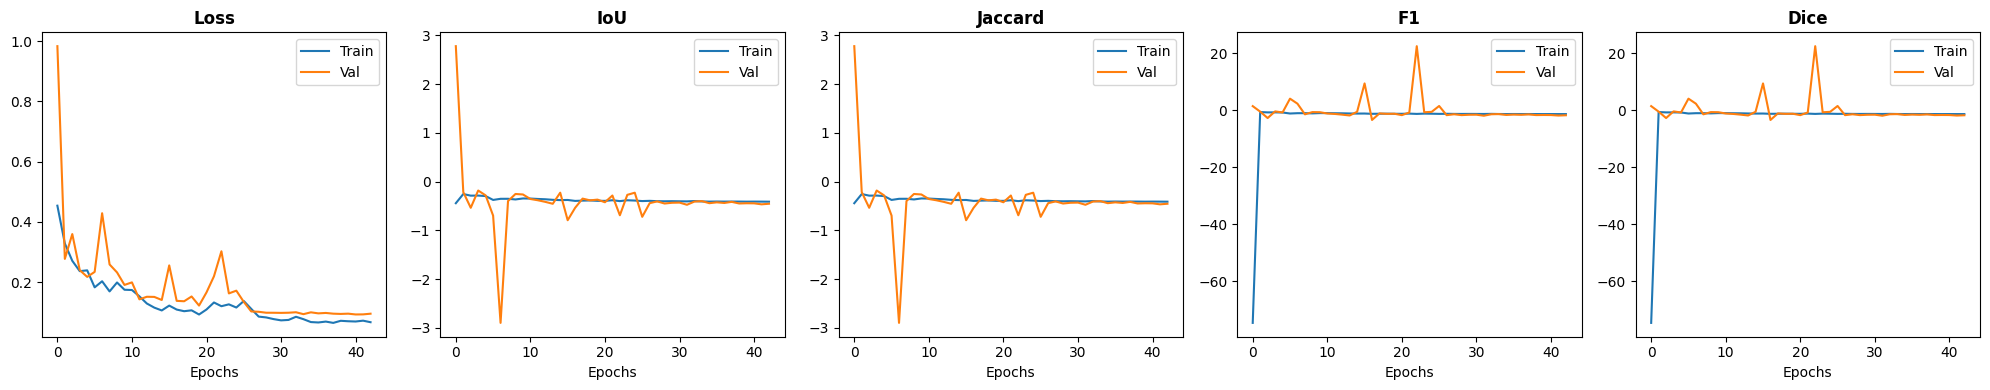

In [21]:
def plot_history(results_dict):
    score_groups = {
        'Loss': ['train_loss_history', 'val_loss_history'],
        'IoU': ['train_iou_history', 'val_iou_history'],
        'Jaccard': ['train_jaccard_history', 'val_jaccard_history'],
        'F1': ['train_f1_history', 'val_f1_history'],
        'Dice': ['train_dice_history', 'val_dice_history']}

    fig, axs = plt.subplots(1, 5, figsize=(20, 4))

    for i, (score_name, score_vars) in enumerate(score_groups.items()):
        axs[i].plot(results_dict[score_vars[0]], label='Train')
        axs[i].plot(results_dict[score_vars[1]], label='Val')
        axs[i].set_title(score_name, fontweight ='bold')
        axs[i].set_xlabel("Epochs")
        axs[i].legend()

    plt.tight_layout()
    plt.show()
    
plot_history(results_dict)

In [22]:
#11- Evaluate model on the test set
def evaluate(model, dataloader, criterion, device):
    model.eval() # model.eval()
    running_loss = 0.0
    running_iou = 0.0
    running_jaccard = 0
    running_f1 = 0
    running_dice = 0
    outputs_test=[]
    with torch.no_grad():
        for images, masks in tqdm(dataloader, leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs_test.append(outputs)
            loss = criterion(outputs, masks)
            
            running_loss += loss.item() * images.size(0)
            running_iou += iou_score(outputs, masks) * images.size(0)
            running_jaccard += jaccard_score(outputs, masks) * images.size(0)
            running_f1 += f1_score(outputs, masks) * images.size(0)
            running_dice += dice_score(outputs, masks) * images.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_iou = running_iou / len(dataloader.dataset)
    epoch_jaccard = running_jaccard / len(dataloader.dataset)
    epoch_f1 = running_f1 / len(dataloader.dataset)
    epoch_dice = running_dice / len(dataloader.dataset)
    
    print(f"Test Loss: {epoch_loss:.4f}, ")
    print(f"Test IoU: {epoch_iou:.4f}, ")
    print(f"Test Jaccard: {epoch_jaccard:.4f}, ")
    print(f"Test F1: {epoch_f1:.4f}, ")
    print(f"Test Dice: {epoch_dice:.4f}, ")
        
    results_dict_test = {
        'Test_Loss': epoch_loss,
        'Test_IoU': epoch_iou,
        'Test_Jaccard': epoch_jaccard,
        'Test_F1': epoch_f1,
        'Test_Dice': epoch_dice}
    
    return results_dict_test

results_dict_test = evaluate(model, test_loader, criterion, device)

Test Loss: 0.0897, 
Test IoU: -0.5836, 
Test Jaccard: -0.5836, 
Test F1: 14.5795, 
Test Dice: 14.5795, 


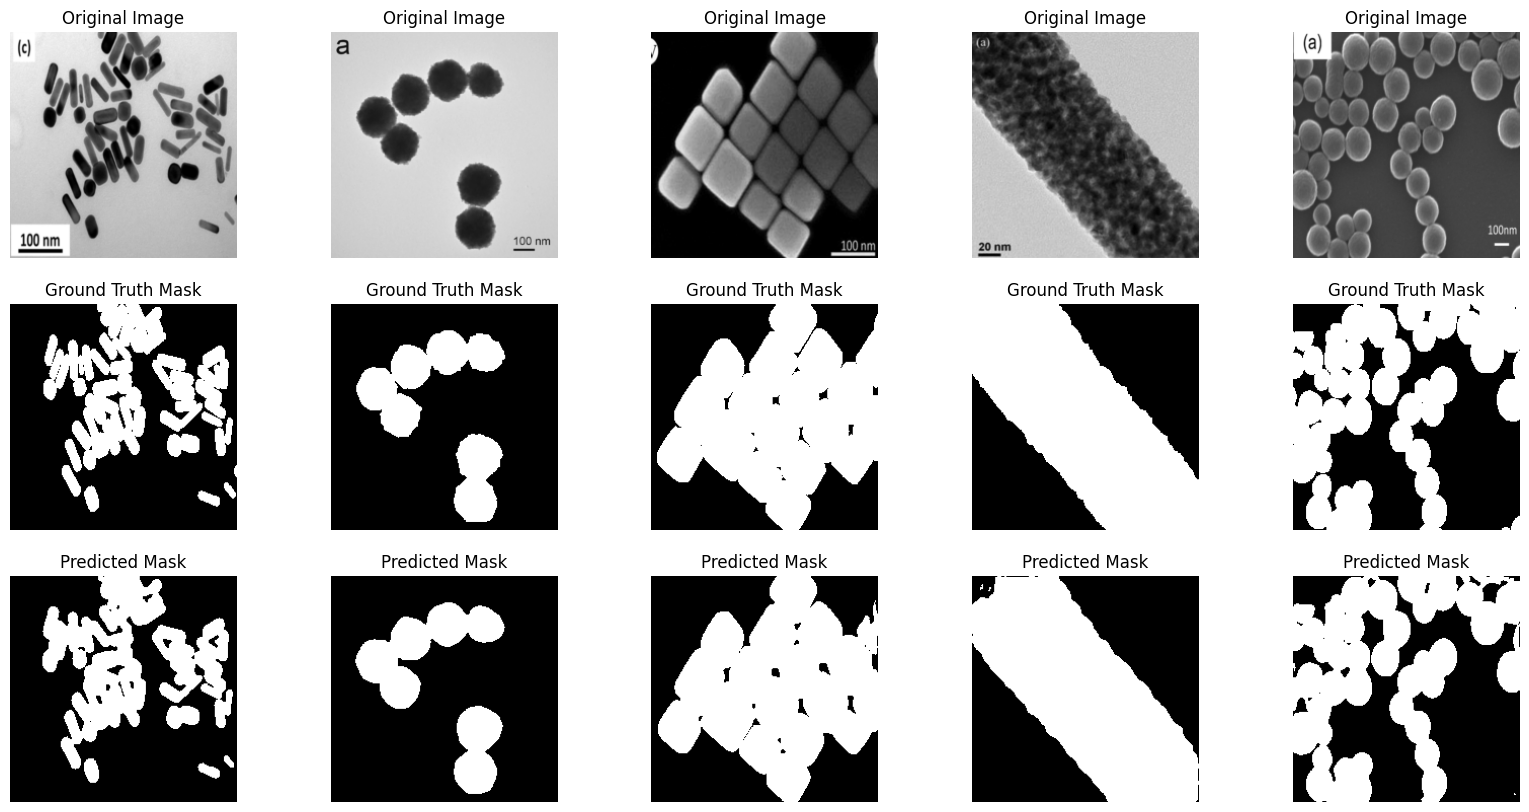

In [23]:
# 12- Plot model evaluated on the test set

# create an instance of the same model architecture
#model = MyModel()
checkpoint = torch.load('best_model_SMP.pth')
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#val_loss = checkpoint['val_loss']
model.eval()
with torch.no_grad():
    # Get a batch of images and masks from the dataloader
    images, masks = next(iter(test_loader))
    # Move the tensors to the device used for training (CPU or GPU)
    images = images.to(device)
    masks = masks.to(device)
    # Get the predicted masks from the model
    outputs = model(images)

    # Convert the tensors to numpy arrays
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    outputs = outputs.cpu().numpy()
    outputs = (outputs > 0.1).astype('uint8') * 255

    # Plot the first 10 images and their corresponding masks and predicted masks
    fig, ax = plt.subplots(3, 5, figsize=(20, 10))
    for i in range(5):
        # Plot the original image
        ax[0, i].imshow(np.transpose(images[i], (1, 2, 0)))
        ax[0, i].axis('off')
        ax[0, i].set_title('Original Image')

        # Plot the ground truth mask
        ax[1, i].imshow(masks[i].squeeze(), cmap='gray')
        ax[1, i].axis('off')
        ax[1, i].set_title('Ground Truth Mask')

        # Plot the predicted mask
        ax[2, i].imshow(outputs[i].squeeze(), cmap='gray')
        ax[2, i].axis('off')
        ax[2, i].set_title('Predicted Mask')

    plt.show()


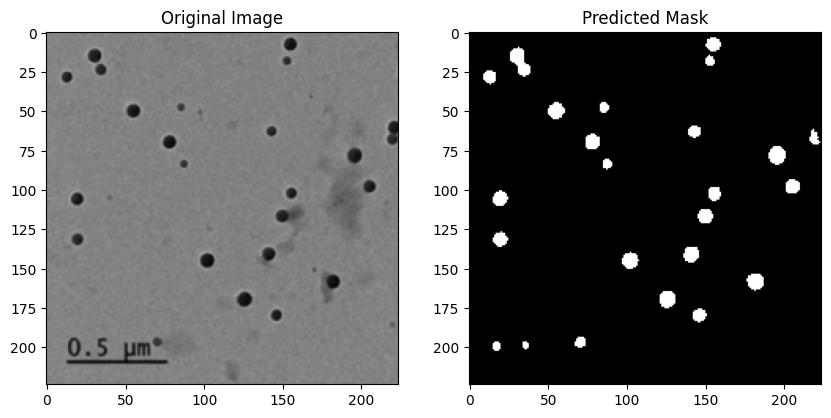

In [30]:
# 13- Use the saved model for inference on new images,
def infer(model, image_path):
    model.eval()
    image_size = (224, 224)
    # Load the image
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    img = transform(img).to(device)
    img=img.unsqueeze(0)

    # Predict the mask
    with torch.no_grad():
        pred_mask = model(img)
    pred_mask = pred_mask > 0.6
    pred_mask = pred_mask.squeeze(0).permute(1, 2, 0).cpu().numpy().astype('uint8') * 255
   
    # Plot the results
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img.squeeze(0).permute(1, 2, 0).cpu().numpy())
    ax[0].set_title('Original Image')
    ax[1].imshow(pred_mask, cmap='gray')
    ax[1].set_title('Predicted Mask')
    plt.show()


all_filenames = os.listdir(image_folder)
img_sample = random.sample(all_filenames, 1)   
# Inference
infer(model, image_folder+img_sample[0])
